# Introduction

## **Project: Sentiment Analysis on Amazon Product Reviews**

With the rise of e-commerce, online product reviews have become crucial for consumers.

Analyzing vast volumes of reviews manually is impractical. Supervised learning models can streamline sentiment analysis on large-scale datasets.

Our **study focuses on categorizing feedback as positive or negative and building an efficient sentiment analysis model.**



In [159]:
FIRST_NAME = "Muthu"
LAST_NAME = "Selvam"
STUDENT_ID = "801276057"

In [160]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [161]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import re
from contractions import contractions_dict
from string import punctuation
import warnings
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/muthuselvam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/muthuselvam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/muthuselvam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Create Amazon Customer Reviews DataFrame from JSON objects

In [162]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('amazon_product_reviews.json.gz')

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]","Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.",4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it helps to have an elevated key.",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [163]:
df = df.dropna(subset = ['reviewText','summary'])
df.isna().sum()

reviewerID           0
asin                 0
reviewerName      3519
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [164]:
print(df['overall'].value_counts())
df['overall'].value_counts(normalize=True) * 100

overall
5.0    108664
4.0     39993
3.0     21439
1.0     13279
2.0     11064
Name: count, dtype: int64


overall
5.0    55.885908
4.0    20.568404
3.0    11.026080
1.0     6.829391
2.0     5.690216
Name: proportion, dtype: float64

## Separate positive and negative reviews for analysis

In [165]:
df_negative_reviews = df[df['overall']<3].iloc[:50000]
df_positive_reviews = df[df['overall']>3].iloc[:50000]

In [166]:
df_new = df.iloc[:100]
df_new.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again,4.0,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),5.0,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,5.0,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]","Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.",4.0,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it helps to have an elevated key.",5.0,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


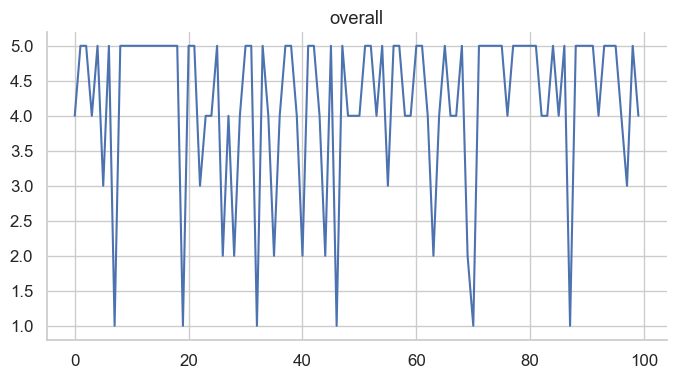

In [167]:
# @title overall

from matplotlib import pyplot as plt
df_new['overall'].plot(kind='line', figsize=(8, 4), title='overall')
plt.gca().spines[['top', 'right']].set_visible(False)

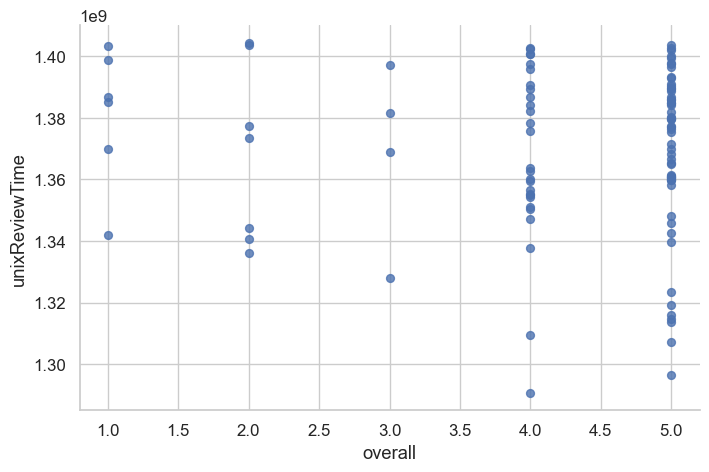

In [168]:
# @title overall vs unixReviewTime

from matplotlib import pyplot as plt
df_new.plot(kind='scatter', x='overall', y='unixReviewTime', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

## Review Text PreProcssing Function Definitions

In [169]:
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text



def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [170]:
from nltk.tokenize import RegexpTokenizer
def cleanme(txt):
    sent = txt.lower()
    sent_expanded_contractions = expand_contractions(sent,contractions_dict)
    sent_expanded_contractions = re.sub(r'(?<=[.,])(?=[^\s])', r' ', sent_expanded_contractions)
    sent_without_punct = strip_punctuation(sent_expanded_contractions)
    sent_without_digits=re.sub('[0-9]+', '', sent_without_punct)

    TOKENIZER = RegexpTokenizer('(?u)\W+|\$[\d\.]+|\S+')
    wrds = word_tokenize(sent_without_digits)
    to_remove = ['no', 'not']
    new_stopwords = set(stopwords.words('english')).difference(to_remove)
    clwrds = [w for w in wrds if not w in new_stopwords]
    ln = len(clwrds)
    if ln>0:
        pos = pd.DataFrame(pos_tag(wrds))
        pos = (" ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))).split(" ")
        l2 = ["i","you","me"]
        pos = [x for x in pos if x not in l2]
    else:
        pos = [""]
    rt = [ln, " ".join(clwrds), " ".join(pos)]
    return(rt)

## Create Negative Reviews WordCloud

**This will take take time to load all the dataset. Please wait.**

In [171]:
tmp = list()
num_rows = min(50000, len(df_negative_reviews))
for i in range(num_rows):
    tmp.append(cleanme(df_negative_reviews.iloc[i,:]['reviewText']))

tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

df_negative_reviews_new = df_negative_reviews.reset_index()
df_negative_reviews_new = pd.concat([df_negative_reviews_new,tmp], axis=1)
df_negative_reviews_new = df_negative_reviews_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_negative_reviews_new.head()


,overall,reviewText,summary,reviewlen,cleanrev,adjreview
0,1.0,it worked for the first week then it only charge my phone to 20%. it is a waste of money.,not a good Idea,7,worked first week charge phone waste money,first
1,1.0,It worked great for the first couple of weeks then it just stopped completely.. so basically a small waste of money.,Horrible,11,worked great first couple weeks stopped completely basically small waste money,great first small
2,2.0,I am disappointed that the 1A didn't work with my iPad. That's what I get for buying a cheap adapter.,This doesn't work with my iPad.,8,disappointed not work ipad get buying cheap adapter,cheap
3,2.0,After a week only one side works,Two Stars,4,week one side works,
4,1.0,"Only works one side at a time. When you connect two cables, one side stop working and also overheated burning the fuses. I purchased two of them and it's the same problem. Cheap and bad quality.","don't waste your money, pay more and buy one at Walgreen s.",21,works one side time connect two cables one side stop working also overheated burning fuses purchased two problem cheap bad quality,same bad


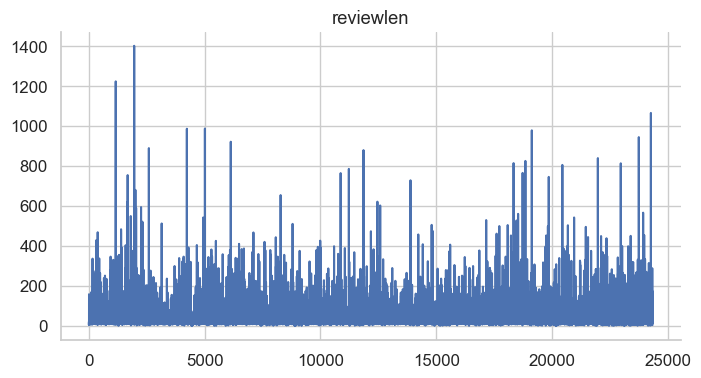

In [172]:
# @title reviewlen

from matplotlib import pyplot as plt
df_negative_reviews_new['reviewlen'].plot(kind='line', figsize=(8, 4), title='reviewlen')
plt.gca().spines[['top', 'right']].set_visible(False)

In [173]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

txt = df_negative_reviews_new.cleanrev.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in words]
bgs = nltk.trigrams(lemmatized_word)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist.most_common(40)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/muthuselvam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[(('would', 'not', 'recommend'), 702),
 (('not', 'waste', 'money'), 329),
 (('not', 'fit', 'phone'), 291),
 (('could', 'not', 'get'), 273),
 (('screen', 'protector', 'not'), 244),
 (('not', 'recommend', 'product'), 240),
 (('case', 'not', 'fit'), 230),
 (('would', 'not', 'buy'), 225),
 (('not', 'work', 'well'), 181),
 (('phone', 'would', 'not'), 162),
 (('not', 'charge', 'phone'), 161),
 (('not', 'last', 'long'), 150),
 (('not', 'worth', 'money'), 150),
 (('not', 'recommend', 'case'), 149),
 (('not', 'recommend', 'anyone'), 146),
 (('would', 'not', 'charge'), 141),
 (('not', 'fit', 'well'), 129),
 (('not', 'work', 'not'), 125),
 (('would', 'not', 'work'), 124),
 (('guess', 'get', 'pay'), 112),
 (('not', 'buy', 'not'), 111),
 (('would', 'not', 'stay'), 110),
 (('not', 'hold', 'charge'), 108),
 (('samsung', 'galaxy', 'note'), 107),
 (('case', 'would', 'not'), 101),
 (('not', 'buy', 'product'), 96),
 (('would', 'not', 'fit'), 95),
 (('not', 'waste', 'time'), 93),
 (('waste', 'time', 'mone

In [174]:
d = {}
for key, value in fdist.items() :
    d["_".join(key)] = value

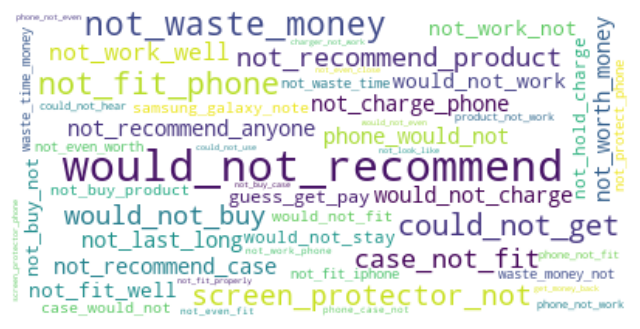

In [175]:
!pip install wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
WC_height = 200
WC_width = 400
WC_max_words = 50
wordcloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("WordCloud_Bigrams_frequent_words.png")

## Create Positive Reviews WordCloud

**This will take take time to load all the dataset. Please wait.**

In [176]:
tmp = list()
for i in range(50000):
    tmp.append(cleanme(df_positive_reviews.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_positive_reviews_new = df_positive_reviews.reset_index()
df_positive_reviews_new = pd.concat([df_positive_reviews_new,tmp], axis=1)
df_positive_reviews_new = df_positive_reviews_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_positive_reviews_new.head()

,overall,reviewText,summary,reviewlen,cleanrev,adjreview
0,4.0,They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again,Looks Good,18,look good stick good not like rounded shape always bumping siri kept popping irritating not buy product like,good stick good rounded
1,5.0,These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),Really great product.,13,stickers work like review says stick great stay phone super stylish share sister,great super stylish
2,5.0,These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,LOVE LOVE LOVE,15,awesome make phone look stylish used one far almost year believe one year great quality,awesome stylish great
3,4.0,"Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.",Cute!,29,item arrived great time perfect condition however ordered buttons great deal included free screen protector never received one though not big deal would nice get since claim comes one,great perfect great free big nice
4,5.0,"awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it helps to have an elevated key.",leopard home button sticker for iphone 4s,13,awesome stays looks great used multiple apple products especially nails helps elevated key,awesome great multiple


In [177]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

wordnet_lemmatizer = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

txt = df_positive_reviews_new.cleanrev.str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
lemmatized_word = [wordnet_lemmatizer.lemmatize(word) for word in words]

bgs = nltk.trigrams(lemmatized_word)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)
fdist.most_common(30)

[(('would', 'recommend', 'anyone'), 335),
 (('would', 'definitely', 'recommend'), 300),
 (('not', 'go', 'wrong'), 276),
 (('would', 'highly', 'recommend'), 276),
 (('not', 'big', 'deal'), 251),
 (('sound', 'quality', 'good'), 242),
 (('last', 'long', 'time'), 239),
 (('not', 'beat', 'price'), 234),
 (('screen', 'protector', 'not'), 222),
 (('htc', 'evo', 'g'), 218),
 (('highly', 'recommend', 'product'), 190),
 (('fit', 'phone', 'perfectly'), 188),
 (('micro', 'usb', 'cable'), 185),
 (('thing', 'not', 'like'), 178),
 (('would', 'recommend', 'product'), 172),
 (('could', 'not', 'happier'), 162),
 (('not', 'add', 'much'), 161),
 (('fit', 'like', 'glove'), 158),
 (('buy', 'another', 'one'), 157),
 (('get', 'job', 'done'), 156),
 (('work', 'like', 'charm'), 156),
 (('hour', 'talk', 'time'), 151),
 (('not', 'work', 'well'), 150),
 (('not', 'much', 'say'), 146),
 (('sound', 'quality', 'great'), 142),
 (('work', 'really', 'well'), 136),
 (('still', 'going', 'strong'), 133),
 (('case', 'fit', '

In [178]:
d = {}
for key, value in fdist.items() :
    d["_".join(key)] = value

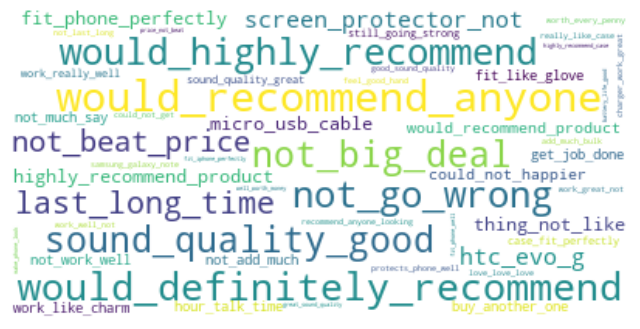

In [179]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
WC_height = 200
WC_width = 400
WC_max_words = 50
wordcloud = WordCloud(max_words=WC_max_words, height=WC_height, width=WC_width, background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("WordCloud_Positive_Reviews.png")

## PreProcess 50,000 reviews to be used to build classification models

**This will take take time to load all the dataset. Please wait.**

In [180]:
df_new = df.iloc[:50000]


tmp = list()
for i in range(50000):
    tmp.append(cleanme(df_new.iloc[i,:]['reviewText']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

(tmp.head())


df_new = df_new.reset_index()
df_new = pd.concat([df_new,tmp], axis=1)
df_new = df_new[['overall','reviewText','summary','reviewlen', 'cleanrev', 'adjreview']]
df_new.head()

,overall,reviewText,summary,reviewlen,cleanrev,adjreview
0,4.0,They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again,Looks Good,18,look good stick good not like rounded shape always bumping siri kept popping irritating not buy product like,good stick good rounded
1,5.0,These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),Really great product.,13,stickers work like review says stick great stay phone super stylish share sister,great super stylish
2,5.0,These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,LOVE LOVE LOVE,15,awesome make phone look stylish used one far almost year believe one year great quality,awesome stylish great
3,4.0,"Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.",Cute!,29,item arrived great time perfect condition however ordered buttons great deal included free screen protector never received one though not big deal would nice get since claim comes one,great perfect great free big nice
4,5.0,"awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it helps to have an elevated key.",leopard home button sticker for iphone 4s,13,awesome stays looks great used multiple apple products especially nails helps elevated key,awesome great multiple


In [181]:
df_new.columns = ['overall_rating','reviewText','summary','cleanReviewLength', 'cleanReview', 'adjectives']
df_new.head()

,overall_rating,reviewText,summary,cleanReviewLength,cleanReview,adjectives
0,4.0,They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again,Looks Good,18,look good stick good not like rounded shape always bumping siri kept popping irritating not buy product like,good stick good rounded
1,5.0,These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),Really great product.,13,stickers work like review says stick great stay phone super stylish share sister,great super stylish
2,5.0,These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,LOVE LOVE LOVE,15,awesome make phone look stylish used one far almost year believe one year great quality,awesome stylish great
3,4.0,"Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.",Cute!,29,item arrived great time perfect condition however ordered buttons great deal included free screen protector never received one though not big deal would nice get since claim comes one,great perfect great free big nice
4,5.0,"awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it helps to have an elevated key.",leopard home button sticker for iphone 4s,13,awesome stays looks great used multiple apple products especially nails helps elevated key,awesome great multiple


## Calculate Polarity of Reviews

In [182]:
!pip install textblob

from textblob import TextBlob, Word
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

df_new['polarity'] = df_new.reviewText.apply(detect_polarity)
df_new[1:10]

,overall_rating,reviewText,summary,cleanReviewLength,cleanReview,adjectives,polarity
1,5.0,These stickers work like the review says they do. They stick on great and they stay on the phone. They are super stylish and I can share them with my sister. :),Really great product.,13,stickers work like review says stick great stay phone super stylish share sister,great super stylish,0.533333
2,5.0,These are awesome and make my phone look so stylish! I have only used one so far and have had it on for almost a year! CAN YOU BELIEVE THAT! ONE YEAR!! Great quality!,LOVE LOVE LOVE,15,awesome make phone look stylish used one far almost year believe one year great quality,awesome stylish great,0.573828
3,4.0,"Item arrived in great time and was in perfect condition. However, I ordered these buttons because they were a great deal and included a FREE screen protector. I never received one. Though its not a big deal, it would've been nice to get it since they claim it comes with one.",Cute!,29,item arrived great time perfect condition however ordered buttons great deal included free screen protector never received one though not big deal would nice get since claim comes one,great perfect great free big nice,0.600000
4,5.0,"awesome! stays on, and looks great. can be used on multiple apple products. especially having nails, it helps to have an elevated key.",leopard home button sticker for iphone 4s,13,awesome stays looks great used multiple apple products especially nails helps elevated key,awesome great multiple,0.360000
5,3.0,These make using the home button easy. My daughter and I both like them. I would purchase them again. Well worth the price.,Cute,12,make using home button easy dter like would purchase well worth price,easy,0.366667
6,5.0,Came just as described.. It doesn't come unstuck and its cute! People ask where I got them from & it's great when driving.,best thing ever..,11,came described not come unstuck cute people ask got great driving,unstuck cute great,0.712500
7,1.0,it worked for the first week then it only charge my phone to 20%. it is a waste of money.,not a good Idea,7,worked first week charge phone waste money,first,0.016667
8,5.0,"Good case, solid build. Protects phone all around with good access to buttons. Battery charges with full battery lasts me a full day. I usually leave my house around 7am and return at 10pm. I'm glad that it lasts from start to end. 5/5",Solid Case,27,good case solid build protects phone around good access buttons battery charges full battery lasts full day usually leave house around return pm glad lasts start end,good solid good full full,0.335714
9,5.0,"This is a fantastic case. Very stylish and protects my phone. Easy access to all buttons and features, without any loss of phone reception. But most importantly, it double power, just as promised. Great buy",Perfect Case,19,fantastic case stylish protects phone easy access buttons features without loss phone reception importantly double power promised great buy,fantastic stylish easy most double great,0.463889


## Naive Bayes Multi-Class Classifier

((29584, 6), (7397, 6))

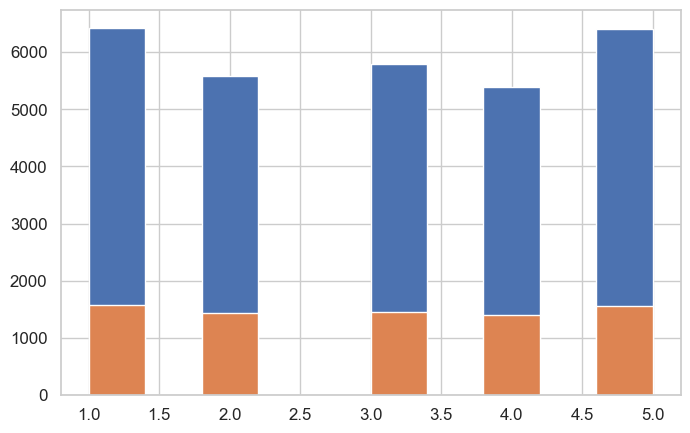

In [183]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import sparse

tfidf = TfidfVectorizer(sublinear_tf=False, max_features = 10000, min_df=5,max_df=0.60,ngram_range= (1,2))

review_df = pd.concat([
    df_new[df_new['overall_rating']==1.0].sample(n=10000, replace=True),
    df_new[df_new['overall_rating']==2.0].sample(n=10000, replace=True),
    df_new[df_new['overall_rating']==3.0].sample(n=10000, replace=True),
    df_new[df_new['overall_rating']==4.0].sample(n=10000, replace=True),
    df_new[df_new['overall_rating']==5.0].sample(n=10000, replace=True)
])

review_df = review_df[review_df['cleanReviewLength']<50]
review_df = review_df[['cleanReview','overall_rating']]
train, test = train_test_split(review_df, test_size=0.2)

train['overall_rating'].hist();
test['overall_rating'].hist();

train = pd.get_dummies(train, columns = ['overall_rating'])
train.head()

test = pd.get_dummies(test, columns = ['overall_rating'])
test.head()

train.shape, test.shape


In [184]:
class NBFeatures(BaseEstimator):
    '''Class implementation of Jeremy Howards NB Linear model'''
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha

    def preprocess_x(self, x, r):
        return x.multiply(r)

    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)

    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self

    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [185]:
# Create pipeline using sklearn pipeline:
    # I basically create my tfidf features which are fed to my NB model
    # for probability calculations. Then those are fed as input to my
    # logistic regression model.
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])

In [186]:
class_names = ['overall_rating_1.0', 'overall_rating_2.0','overall_rating_3.0','overall_rating_4.0','overall_rating_5.0']
scores = []
preds = np.zeros((len(test), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train[class_name]
    cv_score = np.mean(cross_val_score(estimator = p, X = train['cleanReview'].values,
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train['cleanReview'].values, train_target)
    preds[:,i] = p.predict_proba(test['cleanReview'].values)[:,1]

CV score for class overall_rating_1.0 is 0.8771634157978486
CV score for class overall_rating_2.0 is 0.847147122190361
CV score for class overall_rating_3.0 is 0.8210519069798791
CV score for class overall_rating_4.0 is 0.8307193233426546
CV score for class overall_rating_5.0 is 0.8513385679000707


In [187]:
t = metrics.classification_report(np.argmax(test[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

              precision    recall  f1-score   support

           0       0.70      0.84      0.77      1568
           1       0.72      0.60      0.65      1432
           2       0.60      0.54      0.57      1442
           3       0.56      0.42      0.48      1404
           4       0.61      0.78      0.68      1551

    accuracy                           0.64      7397
   macro avg       0.64      0.64      0.63      7397
weighted avg       0.64      0.64      0.63      7397



## Some Analysis

overall_rating
5.0    25975
4.0    10228
3.0     5886
1.0     4477
2.0     3434
Name: count, dtype: int64


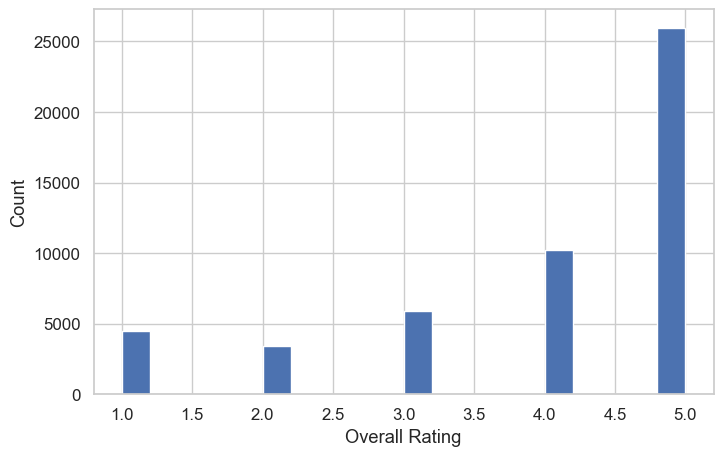

In [188]:
import seaborn as sns
print(df_new['overall_rating'].value_counts())
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    (df_new['overall_rating']), norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Overall Rating', ylabel='Count');

   overall_rating  cleanReviewLength
0             1.0          39.173670
1             2.0          51.669193
2             3.0          49.727952
3             4.0          58.279202
4             5.0          41.432177
   overall_rating  polarity
0             1.0  0.035813
1             2.0  0.109208
2             3.0  0.170273
3             4.0  0.229060
4             5.0  0.308527


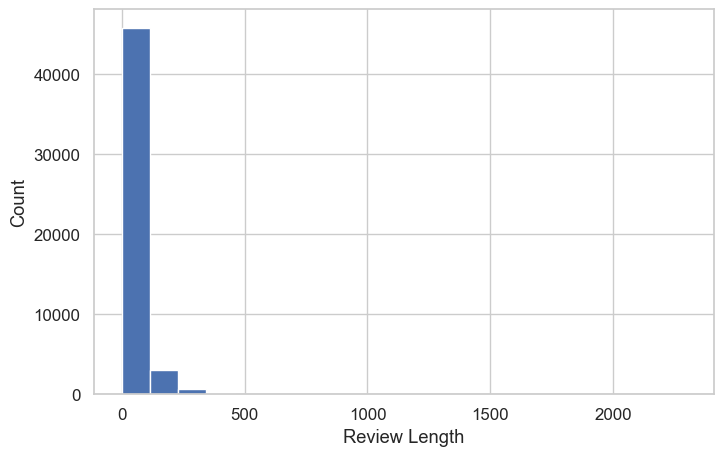

In [189]:
df_res = df_new[df_new['cleanReviewLength']>0]
print(df_res.groupby('overall_rating', as_index=False)['cleanReviewLength'].mean())
print(df_res.groupby('overall_rating', as_index=False)['polarity'].mean())

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    (df_res['cleanReviewLength']), norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Review Length', ylabel='Count');

## Some Other Multi-Class Classifier Models which also takes into account Review Length and Polarity

In [190]:
df_res = pd.concat([
    df_new[df_new['overall_rating']==1.0].sample(n=10000, replace=True),
    df_new[df_new['overall_rating']==2.0].sample(n=10000, replace=True),
    df_new[df_new['overall_rating']==3.0].sample(n=10000, replace=True),
    df_new[df_new['overall_rating']==4.0].sample(n=10000, replace=True),
    df_new[df_new['overall_rating']==5.0].sample(n=10000, replace=True)
])
df_res = df_res[df_res['cleanReviewLength'] < 50]
df_res['overall_rating'].value_counts()


overall_rating
1.0    7999
5.0    7854
3.0    7190
2.0    7040
4.0    6746
Name: count, dtype: int64

In [191]:
df_100 = df_res.copy()

v = TfidfVectorizer(max_features=10000, min_df=5, max_df=0.60)
x = v.fit_transform(df_100['cleanReview'])

df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names_out())
df_100 = df_100.drop('cleanReview', axis=1)

df_100.reset_index(drop=True, inplace=True)
df1.reset_index(drop=True, inplace=True)

res = pd.concat([df_100, df1], axis=1)


In [192]:
res1 = res[res.columns.difference(['reviewText','summary', 'adjectives', 'overall_rating'])]
normalized_res1 = res1
normalized_res1['cleanReviewLength']= (normalized_res1['cleanReviewLength']-normalized_res1['cleanReviewLength'].min())/(normalized_res1['cleanReviewLength'].max()-normalized_res1['cleanReviewLength'].min())
normalized_res1['polarity']= (normalized_res1['polarity']-normalized_res1['polarity'].min())/(normalized_res1['polarity'].max()-normalized_res1['polarity'].min())
y = res['overall_rating'].values.reshape(-1,1)

res1.shape, y.shape

((36829, 6369), (36829, 1))

## Logistic Regression Classifier and ROC Curve

Multinomial Logistic regression Train Accuracy ::  0.7410311237823711
Multinomial Logistic regression Test Accuracy ::  0.6382025522671735
Area under ROC curve::  0.7697138403443414


Text(0.5, 445.55555555555554, 'Predicted label')

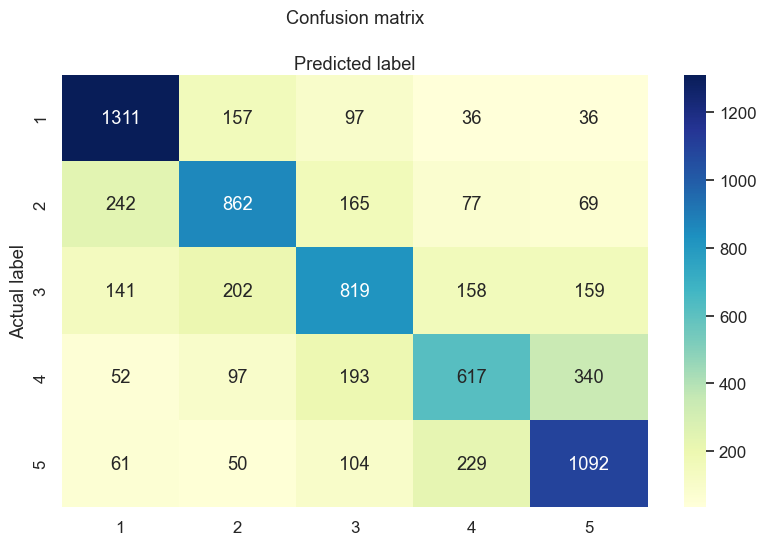

In [193]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(normalized_res1, y, test_size=0.2, random_state= 51)
lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train,y_train)

print ("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print ("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, lr.predict(X_test)))
print ("Area under ROC curve:: ",multiclass_roc_auc_score(y_test,lr.predict(X_test)))

cnf_matrix = metrics.confusion_matrix(y_test, lr.predict(X_test))


class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

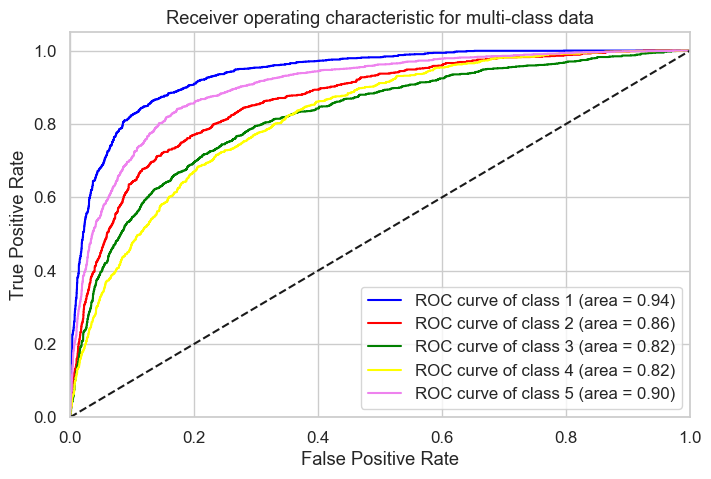

In [194]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


y = label_binarize(y, classes=[1,2,3,4,5])
n_classes = 5

# shuffle and split training and test sets
X_train, X_test, y_train, y_test =train_test_split(normalized_res1, y, test_size=0.2, random_state=51)

# classifier
clf = OneVsRestClassifier(linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg'))
y_score = clf.fit(X_train, y_train).decision_function(X_test)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green', 'yellow', 'violet']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

## SVM Linear Classifier and ROC Curve

Shape of normalized_res1: (36829, 6369)
Shape of y_train_1d: (29463,)
Shape of trimmed normalized_res1: (29463, 6369)
Multinomial SVM Train Accuracy: 0.5044548154433602
Multinomial SVM Test Accuracy: 0.2000678771423723


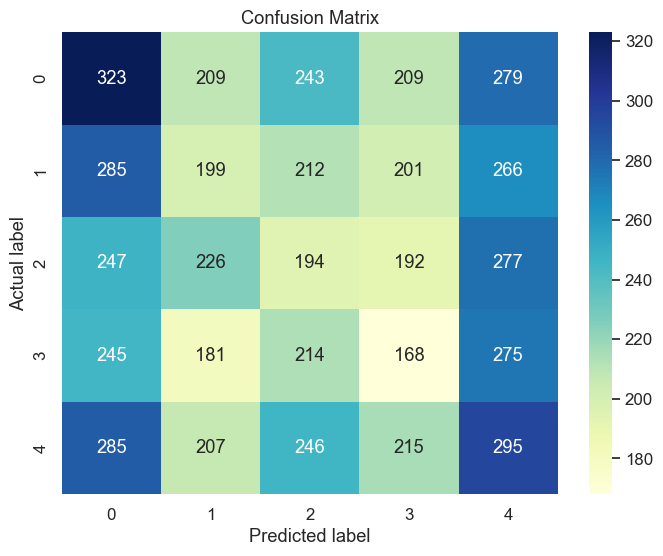

In [206]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming y_train and y_test are one-hot encoded
# Convert them to 1D arrays by selecting the index of the maximum value
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

# Check the shape of normalized_res1 and y_train_1d
print("Shape of normalized_res1:", normalized_res1.shape)
print("Shape of y_train_1d:", y_train_1d.shape)

# Check if the number of samples in y_train_1d is less than the number of samples in normalized_res1
if y_train_1d.shape[0] < normalized_res1.shape[0]:
    # Trim normalized_res1 to match the number of samples in y_train_1d
    normalized_res1_trimmed = normalized_res1[:y_train_1d.shape[0]]
    print("Shape of trimmed normalized_res1:", normalized_res1_trimmed.shape)

    # Use the trimmed normalized_res1 for training
    X_train, X_test, y_train_1d, y_test_1d = train_test_split(normalized_res1_trimmed, y_train_1d, test_size=0.2, random_state=51)
else:
    # Use the original normalized_res1 and y_train_1d for training
    X_train, X_test, y_train_1d, y_test_1d = train_test_split(normalized_res1, y_train_1d, test_size=0.2, random_state=51)

# Train LinearSVC model
svm = LinearSVC()
svm.fit(X_train, y_train_1d)

# Evaluate model performance
train_accuracy = metrics.accuracy_score(y_train_1d, svm.predict(X_train))
test_accuracy = metrics.accuracy_score(y_test_1d, svm.predict(X_test))
print("Multinomial SVM Train Accuracy:", train_accuracy)
print("Multinomial SVM Test Accuracy:", test_accuracy)

# Calculate and display confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_1d, svm.predict(X_test))
class_names = np.unique(y_test_1d)  # Use unique classes from the test set

plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names)
plt.show()


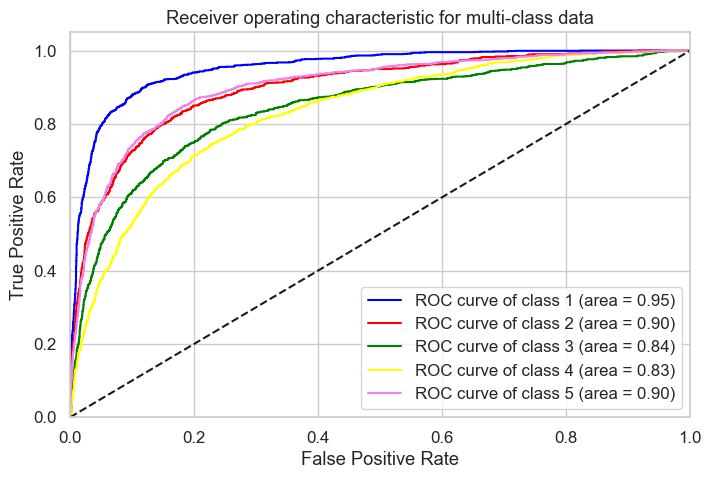

In [198]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
# from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt


y = label_binarize(y, classes=[1,2,3,4,5])
n_classes = 5

# shuffle and split training and test sets
X_train, X_test, y_train, y_test =train_test_split(normalized_res1, y, test_size=0.2, random_state=51)

# classifier
clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(X_train, y_train).decision_function(X_test)


#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green', 'yellow', 'violet']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

## Multinomial Naive Bayes Multi-Class Classifier

Multinomial Naive Bayes Train Accuracy ::  0.7306035263024511
Multinomial Naive Bayes Accuracy ::  0.6077324066029539
Area under ROC curve::  0.7488009083786796


Text(0.5, 445.55555555555554, 'Predicted label')

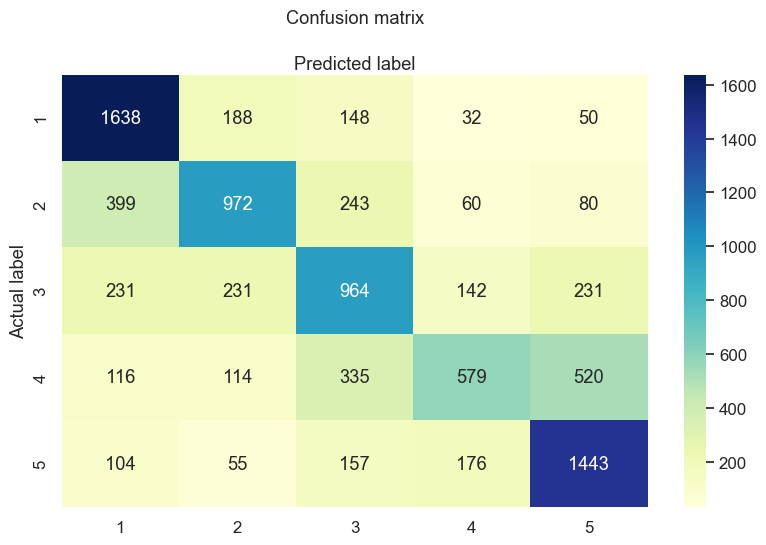

In [197]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df_res['cleanReview'], df_res['overall_rating'], random_state = 51)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
print ("Multinomial Naive Bayes Train Accuracy :: ", metrics.accuracy_score(y_train, clf.predict(X_train_tfidf)))
print ("Multinomial Naive Bayes Accuracy :: ", metrics.accuracy_score(y_test, clf.predict(count_vect.transform(X_test))))
print ("Area under ROC curve:: ",multiclass_roc_auc_score(y_test,clf.predict(count_vect.transform(X_test))))

cnf_matrix = metrics.confusion_matrix(y_test, clf.predict(count_vect.transform(X_test)))
cnf_matrix

class_names=[1,2,3,4,5] # name  of classes
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
# from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt


y = label_binarize(y, classes=[1,2,3,4,5])
n_classes = 5

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_res['cleanReview'], y, random_state = 51)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# classifier
clf = OneVsRestClassifier(MultinomialNB())
y_score = clf.fit(X_train_tfidf, y_train).predict_proba(count_vect.transform(X_test))


#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green', 'yellow', 'violet']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# Accuracy of Result

# Automated data labelling using PCA and generalizing the approach

Automating data labeling using PCA (Principal Component Analysis) for sentiment analysis involves reducing the dimensionality of the data and then using clustering algorithms to group similar data points together.

In this code:


1.   We perform PCA to reduce the dimensionality of the TF-IDF vectorized review data.

2.   We then scale the data and apply PCA to obtain 2 principal components for visualization.

3.   We visualize the PCA components to understand the data distribution.

4.   We use the Elbow Method to determine the optimal number of clusters for KMeans clustering.

5.   We apply KMeans clustering with the optimal number of clusters.

6.   We assign cluster labels to the data.

7.   We visualize the clustered data to see how the data points are grouped.

8.   We label the clusters based on the interpretation of reviews within each cluster.

8.   Finally, we can use these cluster labels as automated data labels for sentiment analysis.

In [ ]:
!pip show scikit-learn

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster._kmeans import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming df_negative_reviews_new contains the preprocessed negative reviews data
# Perform PCA to reduce dimensionality
X = df_negative_reviews_new['cleanrev']
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X = vectorizer.fit_transform(X)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.toarray())

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Components')
plt.show()

# Determine optimal number of clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Based on the elbow method, select optimal number of clusters
optimal_clusters = 3  # Adjust as needed

# Apply KMeans clustering
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels = kmeans.fit_predict(X_pca)

# Assign cluster labels to data
df_negative_reviews_new['cluster_label'] = cluster_labels

# Visualize clustered data
plt.figure(figsize=(8, 6))
for i in range(optimal_clusters):
    plt.scatter(X_pca[cluster_labels == i, 0], X_pca[cluster_labels == i, 1], label=f'Cluster {i}', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('Clustered Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# Conclusion